# Introduction

XGB model with GPU usage by cudf using parameter obtained from Grid Search


Scored 0.80322 for competition's metrics

# Load Libraries

In [1]:
# LOAD LIBRARIES
import pandas as pd, numpy as np # CPU libraries
import cupy, cudf # GPU libraries
import matplotlib.pyplot as plt, gc, os
import seaborn as sns
import gc
import torch
from numba import cuda

print('RAPIDS version',cudf.__version__)
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RAPIDS version 23.04.00


In [2]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 1

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

# Process and Feature Engineer Train Data
We will load @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we will engineer features suggested by @huseyincot in his notebooks [here][3] and [here][4]. We will use [RAPIDS][5] and the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

In [3]:
def check_gpu_memory(status = None):
    
    context = cuda.current_context()
    free_memory, total_memory = context.get_memory_info()
    
    print(status)
    print(f'Total memeory{total_memory}')
    print(f'Free memeory{free_memory}')
    

In [4]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None: df = cudf.read_parquet(path, columns=usecols)
    else: df = cudf.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    df.S_2 = cudf.to_datetime( df.S_2 )
    # SORT BY CUSTOMER AND DATE (so agg('last') works correctly)
    df = df.sort_values(['customer_ID','S_2'])
    df = df.reset_index(drop=True)
    # FILL NAN
    df = df.fillna(NAN_VALUE) 
    print('shape of data:', df.shape)
    
    return df

print('Reading train data...')
TRAIN_PATH = '../input/amex-data-integer-dtypes-parquet-format/train.parquet'
train_raw = read_file(path = TRAIN_PATH)

Reading train data...
shape of data: (5531451, 190)


In [5]:
def process_and_feature_engineer(df):
    
    gc.collect()
    torch.cuda.empty_cache()
    
    #check_gpu_memory('start')
    
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]
    num_diff_features = [ col + '_diff' for col in num_features]
    
    test_num_group = df.groupby("customer_ID")
    
    #test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg = test_num_group[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    
    #Dataframe for diff features
    df_diff = df[['customer_ID','S_2']].copy()
    
    for col in num_features:
        test_num_agg[f'{col}_max_min_diff'] = test_num_agg[f'{col}_max']-test_num_agg[f'{col}_min']
        test_num_agg[f'{col}_last_mean_diff'] = (test_num_agg[f'{col}_last']-test_num_agg[f'{col}_mean']).astype('float32')
        test_num_agg[f'{col}_last_mean_ratio'] = (test_num_agg[f'{col}_last']/test_num_agg[f'{col}_mean']).astype('float32')
        test_num_agg[f'{col}_min_max_ratio'] = (test_num_agg[f'{col}_min']/test_num_agg[f'{col}_max']).astype('float32')
        
        #Extract diff features 
        new_col=col+'_diff'
        df_diff[new_col]= test_num_group[col].diff().fillna(0)

    test_cat_agg = test_num_group[cat_features].agg(['count', 'last', 'nunique'])
    #test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    
    df = cudf.concat([test_num_agg, test_cat_agg], axis=1)
    
    #check_gpu_memory('after agg')
    
    del test_num_agg,test_cat_agg,test_num_group
    print(df.info())
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    #check_gpu_memory('after del test_num_agg,test_cat_agg')
        
    test_num_diff_agg = df_diff.groupby('customer_ID')[num_diff_features].agg(['max'])
    #test_num_diff_agg = df.groupby("customer_ID")[num_diff_features].agg(['mean', 'std','max'])
    test_num_diff_agg.columns = ['_'.join(x) for x in test_num_diff_agg.columns]
        

    df = cudf.concat([df, test_num_diff_agg], axis=1)
    
    #new
    #df = df.fillna(NAN_VALUE)
    #df = df.replace(np.Inf,128)
    #df = df.replace(-np.Inf,-127)
    
    del test_num_diff_agg
    print('shape after engineering', df.shape )
    
    return df

train = process_and_feature_engineer(train_raw)
del train_raw

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 458913 entries, -9223358381327749917 to 9223350112805974911
Columns: 1626 entries, P_2_mean to D_68_nunique
dtypes: float32(903), float64(354), int16(36), int32(22), int8(311)
memory usage: 3.0 GB
None
shape after engineering (458913, 1803)


In [6]:
#train.isna().sum().sum()

In [7]:
# ADD TARGETS
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del targets

# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()

# FEATURES
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

There are 1803 features!


# Train XGB
We will train using `DeviceQuantileDMatrix`. This has a very small GPU memory footprint.

In [8]:
# LOAD XGB LIBRARY
from sklearn.model_selection import KFold
import xgboost as xgb
print('XGB Version',xgb.__version__)

# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=126*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

XGB Version 1.7.5


In [9]:
# https://www.kaggle.com/yunchonggan
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)
    
    #without name for general  calcaution 
    return 0.5 * (gini[1]/gini[0] + top_four)

In [10]:
def amex_metric_mod_xgb(y_pred: np.ndarray, dtrain:xgb.DMatrix):

    y_true     = dtrain.get_label()
    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    #with name to applied in xgboost
    return 'Amex_eval', 0.5 * (gini[1]/gini[0] + top_four)

In [11]:
# XGB MODEL Grid Search PARAMETERS
gs_xgb_parms = { 
    'max_depth':[3,4,5,6],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'learning_rate':[0.05,0.1,0.2,0.3], 
    'subsample':[0.6,0.8,1],
    'colsample_bytree':[0.6],
    'objective':['binary:logistic'],
    'eval_metric':['logloss'],
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'random_state':[SEED]
}

# Grid Search

In [12]:
"""
from sklearn.model_selection import KFold,ParameterGrid

best_score=0
for g in ParameterGrid(gs_xgb_parms):
    importances = []
    oof = []
    #train = train.to_pandas() # free GPU memory
    TRAIN_SUBSAMPLE = 0.1
    gc.collect()

    skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    for fold,(train_idx, valid_idx) in enumerate(skf.split(
                train, train.target )):

        # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
        if TRAIN_SUBSAMPLE<1.0:
            np.random.seed(SEED)
            train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
            np.random.seed(None)

        print('#'*25)
        print('### Fold',fold+1)
        print('### Train size',len(train_idx),'Valid size',len(valid_idx))
        print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
        print('#'*25)

        # TRAIN, VALID, TEST FOR FOLD K
        Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
        X_valid = train.loc[valid_idx, FEATURES]
        y_valid = train.loc[valid_idx, 'target']

        dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
        dvalid = xgb.DMatrix(data=X_valid, label=y_valid)

        # TRAIN MODEL FOLD K
        model = xgb.train(g, 
                    dtrain=dtrain,
                    evals=[(dtrain,'train'),(dvalid,'valid')],
                    num_boost_round=9999,
                    early_stopping_rounds=100,
                    verbose_eval=100) 
        model.save_model(f'XGB_v{VER}_fold{fold}.xgb')

        # GET FEATURE IMPORTANCE FOR FOLD K
        dd = model.get_score(importance_type='weight')
        df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
        importances.append(df)

        # INFER OOF FOLD K
        oof_preds = model.predict(dvalid)
        print(type(y_valid.values))
        print(type(oof_preds))
        acc = amex_metric_mod(y_valid.values.get(), oof_preds)
        print('Kaggle Metric =',acc,'\n')

        # SAVE OOF
        df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
        df['oof_pred'] = oof_preds
        oof.append( df )
        
        # save if best
        if acc > best_score:
            best_score = acc
            best_grid = g  

        del dtrain, Xy_train, dd, df
        del X_valid, y_valid, dvalid, model
        _ = gc.collect()
        
#print('#'*25)
#oof = cudf.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
#acc = amex_metric_mod(oof.target.values.get(), oof.oof_pred.values.get())
#print('OVERALL CV Kaggle Metric =',acc)        
        
        
        
print ("OOB: %0.5f" % best_score )
print ("Grid:", best_grid)
"""

'\nfrom sklearn.model_selection import KFold,ParameterGrid\n\nbest_score=0\nfor g in ParameterGrid(gs_xgb_parms):\n    importances = []\n    oof = []\n    #train = train.to_pandas() # free GPU memory\n    TRAIN_SUBSAMPLE = 0.1\n    gc.collect()\n\n    skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)\n    for fold,(train_idx, valid_idx) in enumerate(skf.split(\n                train, train.target )):\n\n        # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA\n        if TRAIN_SUBSAMPLE<1.0:\n            np.random.seed(SEED)\n            train_idx = np.random.choice(train_idx, \n                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)\n            np.random.seed(None)\n\n        print(\'#\'*25)\n        print(\'### Fold\',fold+1)\n        print(\'### Train size\',len(train_idx),\'Valid size\',len(valid_idx))\n        print(f\'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...\')\n        print(\'#\'*25)\n\n        # TRAIN, VALID, TEST FOR FOLD K\n        X

In [13]:
# best params after grid search
# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':3,
    'gamma': 0.5,
    'learning_rate':0.05, 
    'subsample':0.8,
    'eval_metric':'logloss',
    'colsample_bytree':0.6, 
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

In [14]:
importances = []
oof = []
#train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    print(type(y_valid.values))
    print(type(oof_preds))
    acc = amex_metric_mod(y_valid.values.get(), oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
#print('#'*25)
#oof = cudf.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
#acc = amex_metric_mod(oof.target.values.get(), oof.oof_pred.values.get())
#print('OVERALL CV Kaggle Metric =',acc)

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:1461: FutureWarning: Please use `QuantileDMatrix` instead.
  warnings.warn("Please use `QuantileDMatrix` instead.", FutureWarning)


[0]	train-logloss:0.66392	valid-logloss:0.66389
[100]	train-logloss:0.24374	valid-logloss:0.24516
[200]	train-logloss:0.22817	valid-logloss:0.23111
[300]	train-logloss:0.22238	valid-logloss:0.22625
[400]	train-logloss:0.21876	valid-logloss:0.22359
[500]	train-logloss:0.21626	valid-logloss:0.22205
[600]	train-logloss:0.21418	valid-logloss:0.22096
[700]	train-logloss:0.21245	valid-logloss:0.22017
[800]	train-logloss:0.21087	valid-logloss:0.21952
[900]	train-logloss:0.20944	valid-logloss:0.21911
[1000]	train-logloss:0.20814	valid-logloss:0.21878
[1100]	train-logloss:0.20689	valid-logloss:0.21847
[1200]	train-logloss:0.20572	valid-logloss:0.21829
[1300]	train-logloss:0.20460	valid-logloss:0.21806
[1400]	train-logloss:0.20352	valid-logloss:0.21787
[1500]	train-logloss:0.20245	valid-logloss:0.21767
[1600]	train-logloss:0.20141	valid-logloss:0.21758
[1700]	train-logloss:0.20039	valid-logloss:0.21750
[1800]	train-logloss:0.19937	valid-logloss:0.21738
[1900]	train-logloss:0.19838	valid-logloss:

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:1461: FutureWarning: Please use `QuantileDMatrix` instead.
  warnings.warn("Please use `QuantileDMatrix` instead.", FutureWarning)


[0]	train-logloss:0.66397	valid-logloss:0.66385
[100]	train-logloss:0.24409	valid-logloss:0.24338
[200]	train-logloss:0.22872	valid-logloss:0.22911
[300]	train-logloss:0.22295	valid-logloss:0.22434
[400]	train-logloss:0.21931	valid-logloss:0.22175
[500]	train-logloss:0.21675	valid-logloss:0.22022
[600]	train-logloss:0.21469	valid-logloss:0.21913
[700]	train-logloss:0.21295	valid-logloss:0.21843
[800]	train-logloss:0.21140	valid-logloss:0.21788
[900]	train-logloss:0.20994	valid-logloss:0.21747
[1000]	train-logloss:0.20858	valid-logloss:0.21708
[1100]	train-logloss:0.20733	valid-logloss:0.21687
[1200]	train-logloss:0.20614	valid-logloss:0.21665
[1300]	train-logloss:0.20499	valid-logloss:0.21647
[1400]	train-logloss:0.20385	valid-logloss:0.21635
[1500]	train-logloss:0.20275	valid-logloss:0.21626
[1600]	train-logloss:0.20170	valid-logloss:0.21615
[1700]	train-logloss:0.20067	valid-logloss:0.21603
[1800]	train-logloss:0.19962	valid-logloss:0.21592
[1900]	train-logloss:0.19863	valid-logloss:

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:1461: FutureWarning: Please use `QuantileDMatrix` instead.
  warnings.warn("Please use `QuantileDMatrix` instead.", FutureWarning)


[0]	train-logloss:0.66386	valid-logloss:0.66403
[100]	train-logloss:0.24350	valid-logloss:0.24641
[200]	train-logloss:0.22799	valid-logloss:0.23218
[300]	train-logloss:0.22214	valid-logloss:0.22756
[400]	train-logloss:0.21857	valid-logloss:0.22500
[500]	train-logloss:0.21602	valid-logloss:0.22358
[600]	train-logloss:0.21395	valid-logloss:0.22254
[700]	train-logloss:0.21218	valid-logloss:0.22182
[800]	train-logloss:0.21060	valid-logloss:0.22126
[900]	train-logloss:0.20917	valid-logloss:0.22084
[1000]	train-logloss:0.20786	valid-logloss:0.22055
[1100]	train-logloss:0.20658	valid-logloss:0.22026
[1200]	train-logloss:0.20540	valid-logloss:0.22006
[1300]	train-logloss:0.20426	valid-logloss:0.21984
[1400]	train-logloss:0.20314	valid-logloss:0.21962
[1500]	train-logloss:0.20209	valid-logloss:0.21952
[1600]	train-logloss:0.20103	valid-logloss:0.21934
[1700]	train-logloss:0.20001	valid-logloss:0.21921
[1800]	train-logloss:0.19900	valid-logloss:0.21909
[1900]	train-logloss:0.19800	valid-logloss:

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:1461: FutureWarning: Please use `QuantileDMatrix` instead.
  warnings.warn("Please use `QuantileDMatrix` instead.", FutureWarning)


[0]	train-logloss:0.66388	valid-logloss:0.66403
[100]	train-logloss:0.24318	valid-logloss:0.24679
[200]	train-logloss:0.22785	valid-logloss:0.23239
[300]	train-logloss:0.22200	valid-logloss:0.22775
[400]	train-logloss:0.21837	valid-logloss:0.22527
[500]	train-logloss:0.21576	valid-logloss:0.22373
[600]	train-logloss:0.21367	valid-logloss:0.22276
[700]	train-logloss:0.21195	valid-logloss:0.22209
[800]	train-logloss:0.21031	valid-logloss:0.22151
[900]	train-logloss:0.20886	valid-logloss:0.22110
[1000]	train-logloss:0.20754	valid-logloss:0.22088
[1100]	train-logloss:0.20632	valid-logloss:0.22060
[1200]	train-logloss:0.20511	valid-logloss:0.22037
[1300]	train-logloss:0.20394	valid-logloss:0.22020
[1400]	train-logloss:0.20282	valid-logloss:0.22003
[1500]	train-logloss:0.20176	valid-logloss:0.21988
[1600]	train-logloss:0.20070	valid-logloss:0.21980
[1700]	train-logloss:0.19966	valid-logloss:0.21969
[1800]	train-logloss:0.19865	valid-logloss:0.21957
[1900]	train-logloss:0.19763	valid-logloss:

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:1461: FutureWarning: Please use `QuantileDMatrix` instead.
  warnings.warn("Please use `QuantileDMatrix` instead.", FutureWarning)


[0]	train-logloss:0.66399	valid-logloss:0.66392
[100]	train-logloss:0.24408	valid-logloss:0.24351
[200]	train-logloss:0.22884	valid-logloss:0.22914
[300]	train-logloss:0.22303	valid-logloss:0.22442
[400]	train-logloss:0.21945	valid-logloss:0.22181
[500]	train-logloss:0.21703	valid-logloss:0.22040
[600]	train-logloss:0.21490	valid-logloss:0.21924
[700]	train-logloss:0.21315	valid-logloss:0.21847
[800]	train-logloss:0.21160	valid-logloss:0.21789
[900]	train-logloss:0.21014	valid-logloss:0.21741
[1000]	train-logloss:0.20877	valid-logloss:0.21704
[1100]	train-logloss:0.20753	valid-logloss:0.21677
[1200]	train-logloss:0.20632	valid-logloss:0.21649
[1300]	train-logloss:0.20553	valid-logloss:0.21672
[1386]	train-logloss:0.20440	valid-logloss:0.21634
<class 'cupy.ndarray'>
<class 'numpy.ndarray'>
Kaggle Metric = 0.7955916272999937 



In [15]:
print('#'*25)
oof = cudf.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values.get(), oof.oof_pred.values.get())
print('OVERALL CV Kaggle Metric =',acc)

#########################
OVERALL CV Kaggle Metric = 0.7925530118793913


In [16]:
# CLEAN RAM
del train
_ = gc.collect()

# Save OOF Preds

In [17]:
oof=oof.to_pandas()

In [18]:
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID_hash')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()

,customer_ID,target,oof_pred
0,20eac26171c3d251c55fc78204e59fab1c15fc2bc96d0c...,1,0.757115
1,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...,0,0.000630
2,32cd2d41aef737b69089882754395925c96eaee1f4a859...,0,0.002148
3,8daa6d5dc2655a8a437531e6b8b96829113cdfe9bf6cae...,0,0.012923
4,0ceba351a3851202542feb49d7385bcef32f6037fc57c7...,1,0.855533


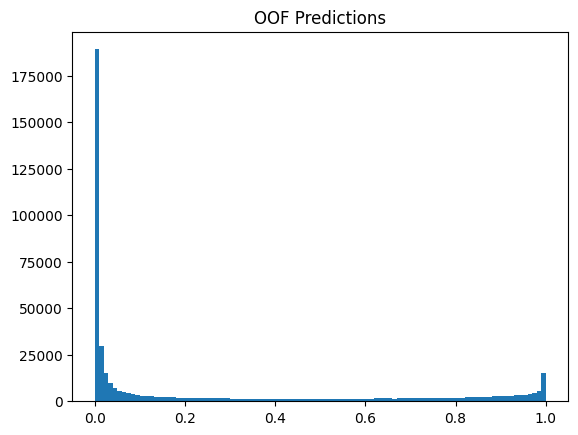

In [19]:
# PLOT OOF PREDICTIONS
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

In [20]:
# CLEAR VRAM, RAM FOR INFERENCE BELOW
del oof_xgb, oof
_ = gc.collect()

# Feature Importance

In [21]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

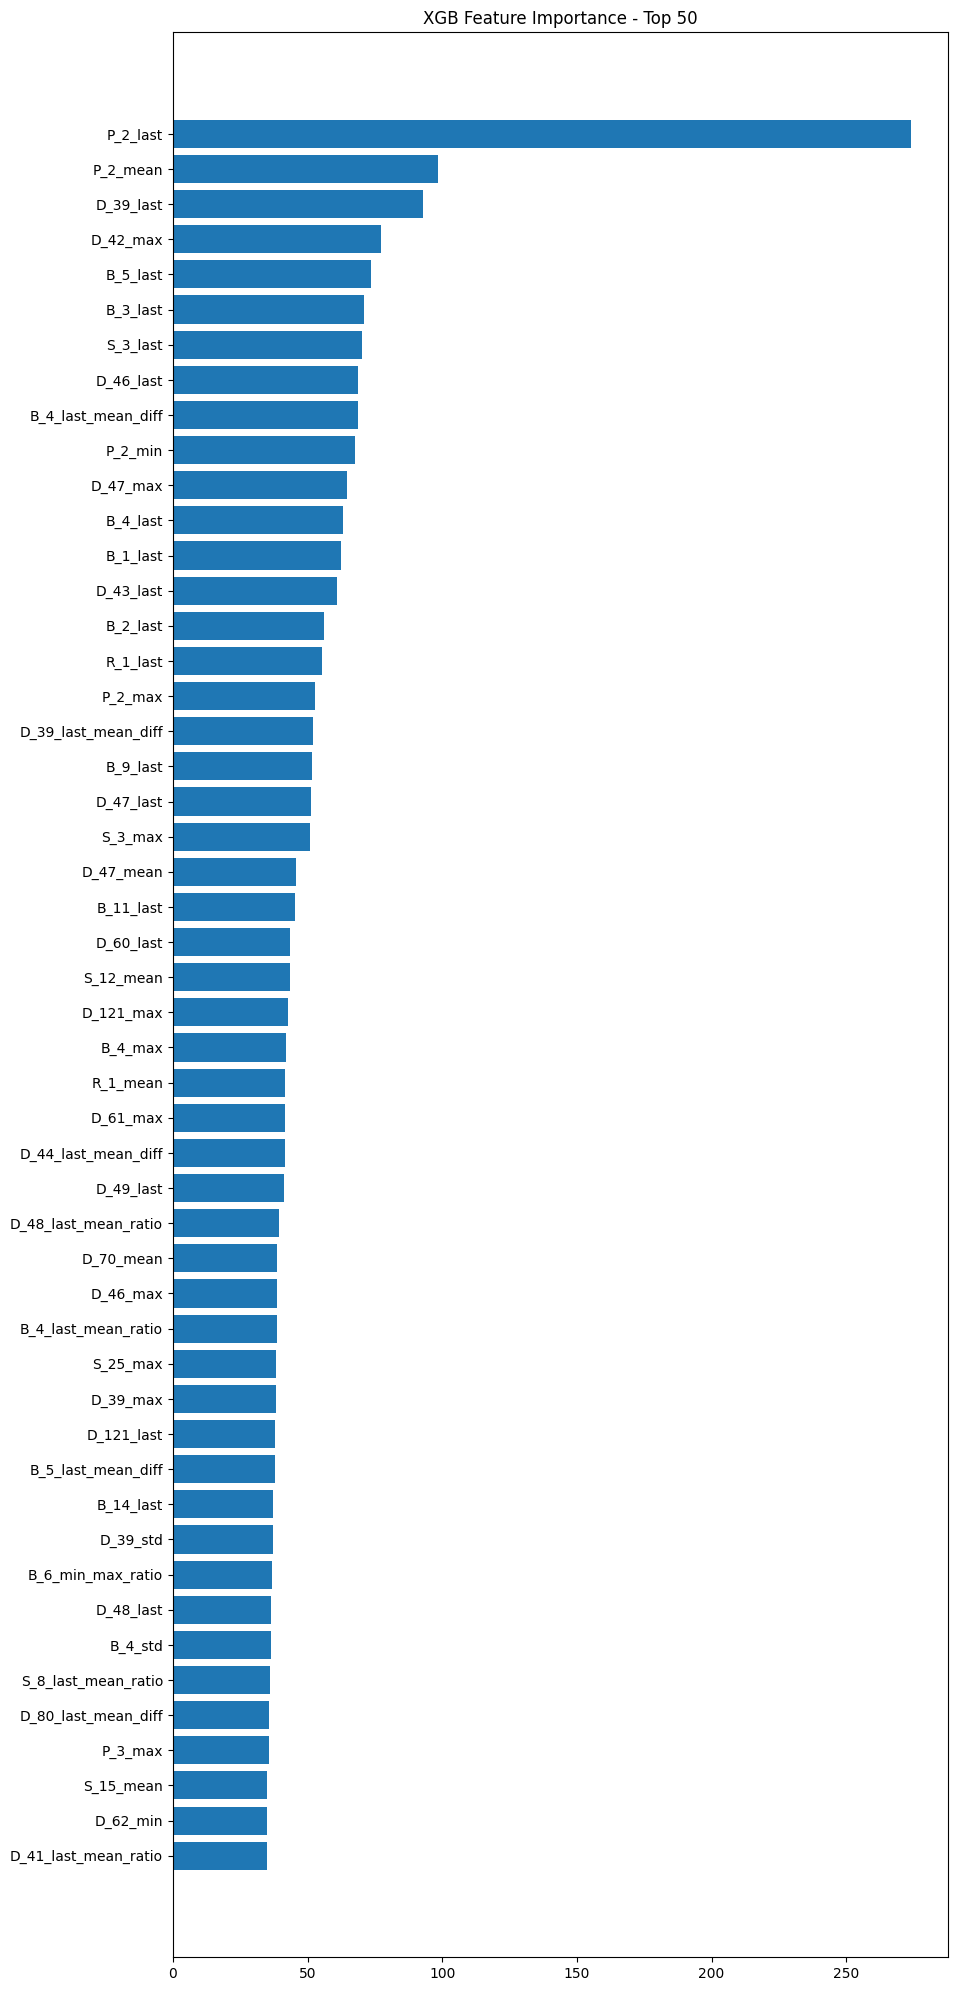

In [22]:
NUM_FEATURES = 50
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Process and Feature Engineer Test Data
We will load @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we will engineer features suggested by @huseyincot in his notebooks [here][1] and [here][4]. We will use [RAPIDS][5] and the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

In [23]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4
TEST_PATH = '../input/amex-data-integer-dtypes-parquet-format/test.parquet'

print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2839373, 2841795, 2841688, 2840906]


# Infer Test

In [24]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = process_and_feature_engineer(test)
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    test = test[['P_2_mean']] # reduce memory
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (2839373, 190)
<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 231155 entries, -9223277493928322471 to -4609390862609427552
Columns: 1626 entries, P_2_mean to D_68_nunique
dtypes: float32(903), float64(354), int16(40), int32(22), int8(307)
memory usage: 1.5 GB
None
shape after engineering (231155, 1803)

Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (2841795, 190)
<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 231155 entries, -4609389626922867490 to 12245257319079158
Columns: 1626 entries, P_2_mean to D_68_nunique
dtypes: float32(903), float64(354), int16(40), int32(22), int8(307)
memory usage: 1.5 GB
None
shape after engineering (231155, 1803)

Reading test data...
shape of data: (11363762, 190)
=> Test part 3 has shape (2841688, 190)
<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 231155 entries, 12246988374112547 to 4631490280094092086
Columns: 1626 entries, P_2_

# Create Submission CSV

In [25]:
# WRITE SUBMISSION FILE
test_preds = np.concatenate(test_preds)
test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
sub = cudf.read_csv('../input/amex-default-prediction/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()

Submission file shape is (924621, 2)


,customer_ID,prediction
0,03d0e43de1d9c5d73ba189b9b176259c0976768537db67...,0.472613
1,03d14a30c863e0fe2addc0d1c319786544bb7225f6caf7...,0.001253
2,03d132deef75e18269bd983ffa54d7c6655666e0eee8f8...,0.014371
3,03d19da24502b694a607bf9d92083385f3825b4aca6308...,0.901569
4,03d0fb061f1987be6a879645e8aca959a2993756951ed4...,0.086595


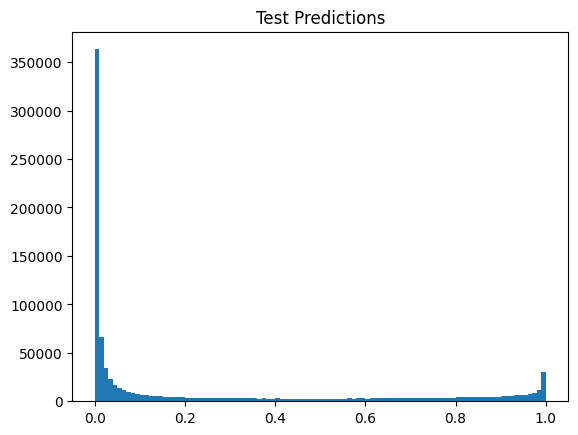

In [26]:
# PLOT PREDICTIONS
plt.hist(sub.to_pandas().prediction, bins=100)
plt.title('Test Predictions')
plt.show()